In [29]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torch

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use("ggplot")


Load Fashion-MNIST data & build matrix X

In [30]:
data_dir = "../data"

transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


Now build matrix X of flatten images

In [31]:
n_samples = 10000  # you can increase later once everything works

images = []
labels = []

for i in range(n_samples):
    img, label = train_dataset[i]  # img shape: (1, 28, 28)
    img = img.squeeze(0)           # -> (28, 28)
    images.append(img.numpy().reshape(-1))  # -> (784,)
    labels.append(label)

X = np.stack(images, axis=0)  # shape: (n_samples, 784)
y = np.array(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (10000, 784)
y shape: (10000,)


look at one image (sanity check)

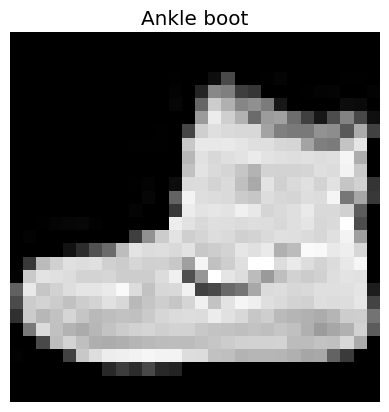

In [32]:
idx = 0
plt.imshow(X[idx].reshape(28, 28), cmap="gray")
plt.title(class_names[y[idx]])
plt.axis("off")
plt.show()


Fit PCA (full) and inspect variance

In [6]:
pca_full = PCA(n_components=784)  # max possible # Find up to 784 principal components.
pca_full.fit(X)


,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",784
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SV

components_ → rows = principal directions (eigenvectors) in pixel space

explained_variance_ → eigenvalues (variance along each PC)

singular_values_ → singular values (related to SVD)

In [34]:
print("Components shape:", pca_full.components_.shape)   # (784, 784)
print("Explained variance shape:", pca_full.explained_variance_.shape)
print("Singular values shape:", pca_full.singular_values_.shape)


Components shape: (784, 784)
Explained variance shape: (784,)
Singular values shape: (784,)


Plot explained variance ratio

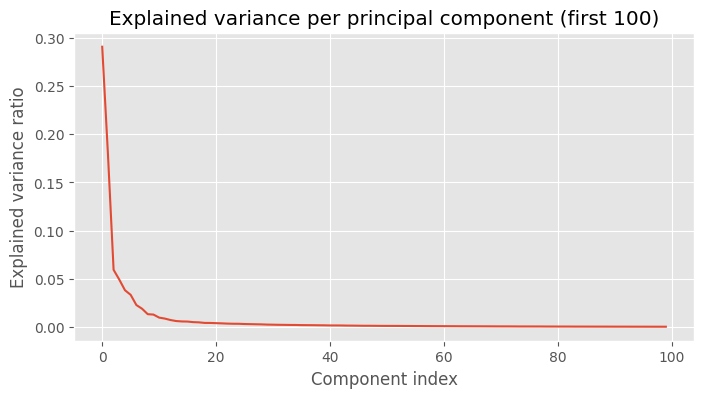

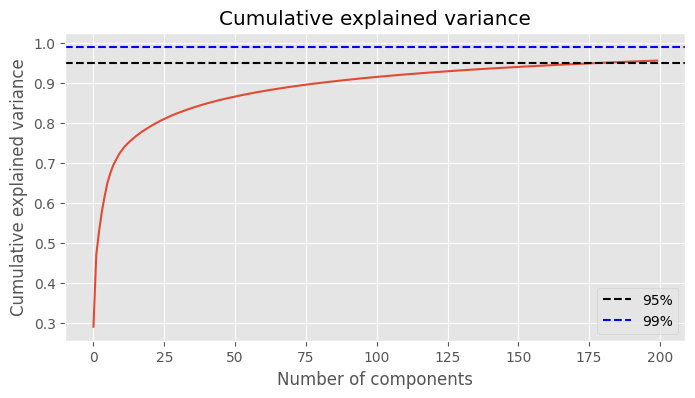

In [36]:
expl_var_ratio = pca_full.explained_variance_ratio_
cum_expl_var = np.cumsum(expl_var_ratio)

plt.figure(figsize=(8,4))
plt.plot(expl_var_ratio[:100])
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio")
plt.title("Explained variance per principal component (first 100)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(cum_expl_var[:200])
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance")
plt.axhline(0.95, color="black", linestyle="--", label="95%")
plt.axhline(0.99, color="blue", linestyle="--", label="99%")
plt.legend()
plt.show()


print how many PCs you need for 95% or 99% variance

In [37]:
n_95 = np.argmax(cum_expl_var >= 0.95) + 1
n_99 = np.argmax(cum_expl_var >= 0.99) + 1

print(f"Components for 95% variance: {n_95}")
print(f"Components for 99% variance: {n_99}")


Components for 95% variance: 182
Components for 99% variance: 445


Visualize principal components as "eigen-images"

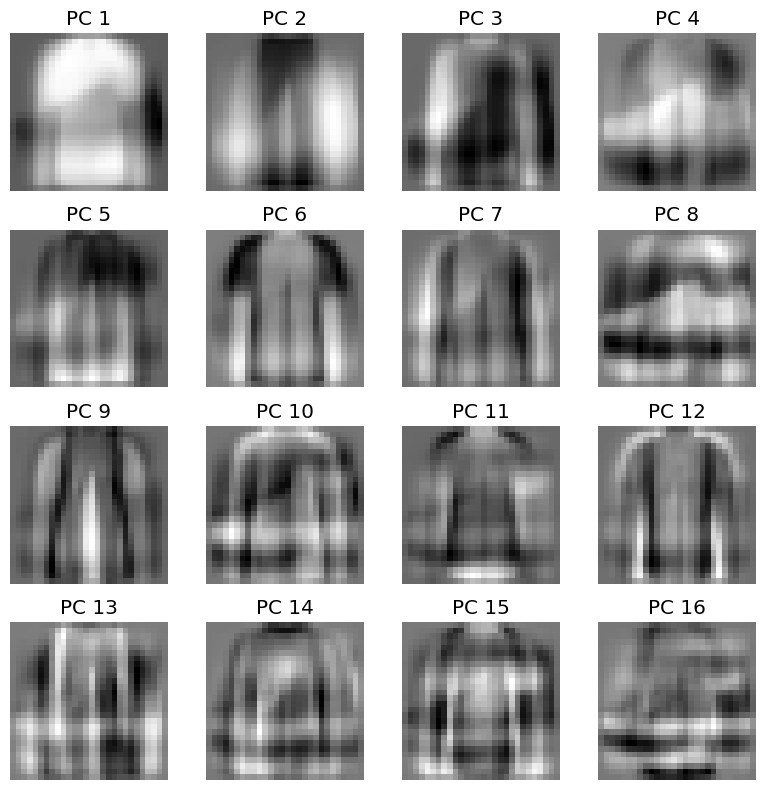

In [10]:
def plot_pcs_as_images(pca, n_components=16):
    pcs = pca.components_[:n_components]
    n_rows = int(np.sqrt(n_components))
    n_cols = int(np.ceil(n_components / n_rows))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= n_components:
            ax.axis("off")
            continue
        pc_img = pcs[i].reshape(28, 28)
        ax.imshow(pc_img, cmap="gray")
        ax.set_title(f"PC {i+1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_pcs_as_images(pca_full, n_components=16)


Reconstruct images with different numbers of components

compression & reconstruction. pick a list of k values

In [42]:
k_values = [10, 20, 50, 100, 200]


define a helper

In [43]:
def pca_reconstruct(X, n_components):
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)          # projection to k-dim
    X_reconstructed = pca.inverse_transform(X_transformed)  # back to pixel space
    return X_reconstructed, pca


reconstruct for each k and compute MSE on, say, first 1000 images for speed

In [44]:
n_eval = 1000
X_eval = X[:n_eval]

recon_errors = {}

for k in k_values:
    X_rec_k, _ = pca_reconstruct(X_eval, n_components=k)
    mse_k = mean_squared_error(X_eval, X_rec_k)
    recon_errors[k] = mse_k
    print(f"k = {k:3d}, MSE = {mse_k:.6f}")


k =  10, MSE = 0.023913
k =  20, MSE = 0.017940
k =  50, MSE = 0.010892
k = 100, MSE = 0.006306
k = 200, MSE = 0.002599


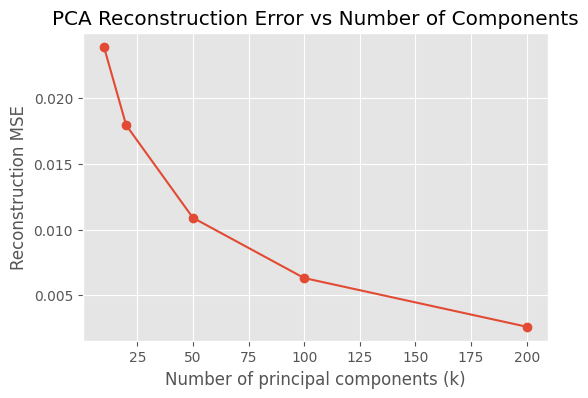

In [45]:
plt.figure(figsize=(6,4))
plt.plot(list(recon_errors.keys()), list(recon_errors.values()), marker="o")
plt.xlabel("Number of principal components (k)")
plt.ylabel("Reconstruction MSE")
plt.title("PCA Reconstruction Error vs Number of Components")
plt.show()


Visual comparison: original vs reconstructed

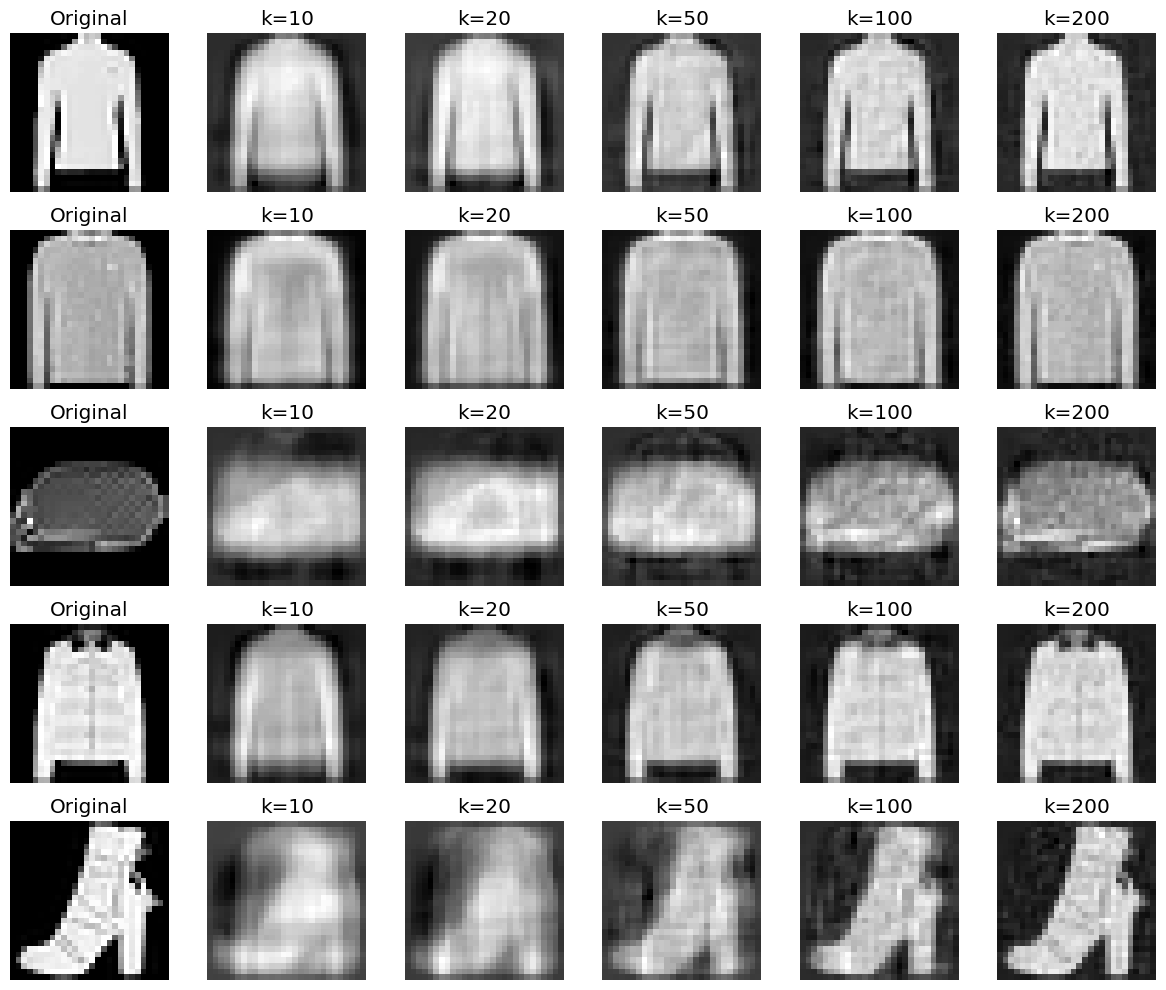

In [46]:
def show_reconstructions(X_original, k_list, n_images=5):
    """
    X_original: (n_samples, 784)
    k_list: list of k values for PCA
    n_images: how many random images to show
    """
    idxs = np.random.choice(X_original.shape[0], size=n_images, replace=False)

    # For each k, compute reconstructed set (only once)
    recon_by_k = {}
    for k in k_list:
        X_rec_k, _ = pca_reconstruct(X_original, n_components=k)
        recon_by_k[k] = X_rec_k

    n_cols = 1 + len(k_list)  # original + each k
    fig, axes = plt.subplots(n_images, n_cols, figsize=(n_cols * 2, n_images * 2))

    for row, idx in enumerate(idxs):
        # original
        axes[row, 0].imshow(X_original[idx].reshape(28, 28), cmap="gray")
        axes[row, 0].set_title("Original")
        axes[row, 0].axis("off")

        # each reconstruction
        for col, k in enumerate(k_list, start=1):
            axes[row, col].imshow(recon_by_k[k][idx].reshape(28, 28), cmap="gray")
            axes[row, col].set_title(f"k={k}")
            axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

show_reconstructions(X_eval, k_values, n_images=5)


compute PCA MSE for k=64 to compare with AE (latent_dim=64)

In [47]:

X_eval = X[:1000]
X_rec_64, _ = pca_reconstruct(X_eval, n_components=64)
pca_64_mse = mean_squared_error(X_eval, X_rec_64)
print("PCA k=64 MSE:", pca_64_mse)


PCA k=64 MSE: 0.009167523123323917


## PCA Summary & Observations

- Each Fashion-MNIST image (28×28) was treated as a 784-dimensional vector.
- PCA learned a new orthogonal basis (principal components) that captures directions of maximum variance in the data.

**Explained variance:**

- ~95% of the variance is captured by the first **182** components.
- ~99% of the variance is captured by the first **445** components.

This means that although the raw pixel space is 784-dimensional, the *effective* dimensionality of the dataset is much lower.

**Reconstruction quality:**

Using PCA with different numbers of components (k), the reconstruction MSE on a held-out subset (~1000 images) was:

- k = 10  → MSE ≈ 0.0239  
- k = 20  → MSE ≈ 0.0179  
- k = 50  → MSE ≈ 0.0109  
- k = 100 → MSE ≈ 0.0063  
- k = 200 → MSE ≈ 0.0026  

As k increases, reconstruction error decreases and the images become visually sharper. However, the gains beyond ~200 components are smaller (diminishing returns).

**Takeaway:**

PCA provides a strong **linear** dimensionality reduction method for Fashion-MNIST:
- It dramatically reduces dimensionality (784 → ~100–200) while retaining most of the structure.
- It gives interpretable components and clear variance-explained curves.

Next, I will compare this **linear** method to a **nonlinear autoencoder** that learns a compressed latent representation using a neural network, and compare reconstruction quality and latent structure.
